In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
from dataset import *


In [2]:
dataset_dir = './VOC/VOCdevkit/VOC2012'
crop_size = (224, 320)
train_dataset = VOCSegmentDataset(dataset_dir, crop_size, is_train = True)

Resize shape: (235, 335)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


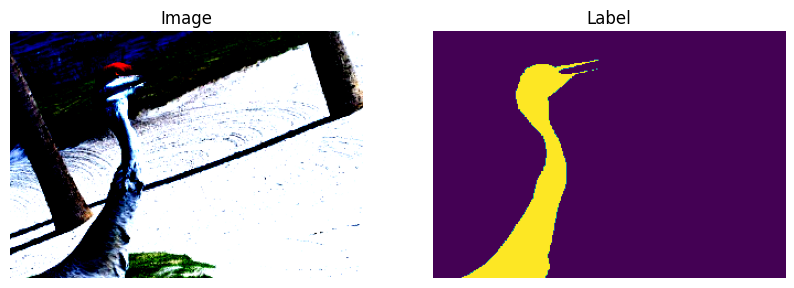

In [3]:
image, segmentation = train_dataset[3]
train_dataset.draw_image_label(image, segmentation)

In [4]:
len(train_dataset)

1448

### FCN Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.vgg as vgg

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# pretrained_model = models.vgg16(weights = 'IMAGENET1K_V1')

# pretrained_model.to(device)

In [7]:
# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}


cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [8]:
def make_layers(cfg, batch_norm = False):
    layers = []
    in_channels = 3

    for v in cfg:
        if v == 'M':
            layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size = 3, padding = 1)
            if batch_norm:
                layers.extend([conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace = True)])
            else:
                layers.extend([conv2d, nn.ReLU(inplace = True)])

            in_channels = v

    return nn.Sequential(*layers)

make_layers(cfg['vgg16'])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
class VGGNet(vgg.VGG):
    # We will load the weight from IMAGENETV1
    def __init__(self, pretrained = True, model = 'vgg16',  requires_grad = True, 
                 remove_fc = True):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]
        model_urls = {
            'vgg11': 'https://download.pytorch.org/models/vgg11-8a719046.pth',
            'vgg13': 'https://download.pytorch.org/models/vgg13-19584684.pth',
            'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
            'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'
        }

        if pretrained:
            state_dict = torch.hub.load_state_dict_from_url(model_urls[model], 
                                                            progress = True)
            self.load_state_dict(state_dict)
            
        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:
            del self.classifier
            
    def forward(self, x):
        output = {}

        for idx, (start, end) in enumerate(self.ranges):
            for layer in range(start, end):
                x = self.features[layer](x)

            output[f'pool_{idx + 1}'] = x

        return output

vgg16_pretrained = VGGNet().to(device)
vgg16_pretrained

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [10]:
input = torch.randn(16, 3, 224, 320).to(device)
output = vgg16_pretrained(input)
pool_5 = output['pool_5']

pool_5.shape

torch.Size([16, 512, 7, 10])

In [11]:
output

{'pool_1': tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.1952e+00,
            0.0000e+00, 1.3951e+00],
           [0.0000e+00, 0.0000e+00, 4.4553e+00,  ..., 5.0893e+00,
            0.0000e+00, 3.9120e+00],
           [1.5562e-01, 0.0000e+00, 5.2142e-01,  ..., 3.2104e+00,
            0.0000e+00, 3.1181e+00],
           ...,
           [0.0000e+00, 3.8018e+00, 1.3732e+00,  ..., 3.7300e-01,
            2.1822e+00, 3.3651e+00],
           [1.0576e+00, 2.2839e+00, 6.3793e-01,  ..., 5.8494e-01,
            2.9681e+00, 9.4987e-01],
           [0.0000e+00, 4.2555e-02, 5.7888e+00,  ..., 1.0684e+00,
            3.6106e+00, 1.7384e+00]],
 
          [[5.9564e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4226e+00,
            0.0000e+00, 2.3702e+00],
           [7.3906e+00, 0.0000e+00, 1.8031e+00,  ..., 1.6424e+00,
            0.0000e+00, 2.3513e+00],
           [1.0142e+00, 8.0905e-01, 1.9274e+00,  ..., 1.8425e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [6.1836e-01, 3.15

In [12]:
pool_4 = output['pool_4']
pool_4.shape

torch.Size([16, 512, 14, 20])